In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (
    Dataset, random_split, DataLoader)

import torchvision
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

In [2]:
torch.__version__, torch.cuda.is_available()

('1.7.1+cu101', True)

In [3]:
dataset = ImageFolder('./Images')

In [4]:
breeds = []

def rename(name):
    return ' '.join(
        ' '.join(
            name.split('-')[1:]
        ).split('_')
    )

for n in dataset.classes:
    breeds.append(rename(n))

In [5]:
breeds.__len__()

120

In [6]:
SEED = 45
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [7]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size

train_ds, val_ds, test_ds = random_split(
    dataset, [train_size, val_size, test_size]
)
len(train_ds), len(val_ds), len(test_ds)

(12966, 1440, 6174)

n02107908-Appenzeller
<class 'PIL.Image.Image'>


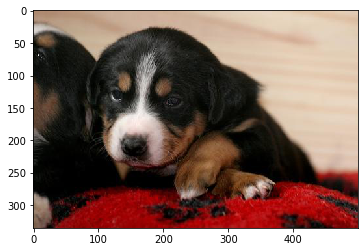

In [8]:
img, label = train_ds[6]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

In [9]:
for i in range(10):
    print(np.array(train_ds[i][0]).shape)

(375, 500, 3)
(500, 449, 3)
(333, 500, 3)
(315, 500, 3)
(500, 375, 3)
(164, 233, 3)
(335, 500, 3)
(240, 320, 3)
(375, 500, 3)
(375, 500, 3)


In [10]:
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
        return img, label

In [11]:
imagenet_stats = (
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
)

train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
    
])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

In [12]:
train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

89


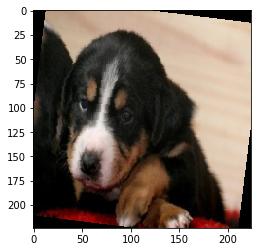

In [13]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [20]:
batch_size = 16

# Create DataLoaders
train_dl = DataLoader(
    train_dataset,
    batch_size, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True
)
val_dl = DataLoader(
    val_dataset, 
    batch_size*2, 
    num_workers=0, 
    pin_memory=True
)
test_dl = DataLoader(
    test_dataset, 
    batch_size*2, 
    num_workers=0, 
    pin_memory=True
)

In [21]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

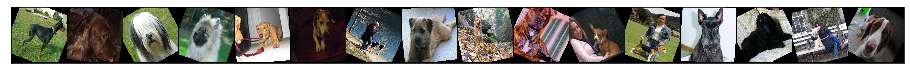

In [22]:
show_batch(train_dl)

In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(
        torch.sum(preds == labels).item() / len(preds)
    )

In [24]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print(
            f"Epoch [{epoch}] : train_loss: {result['train_loss']:.4f}, "
            f"val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}"
        )

In [19]:
p = 1
k = 5
d = 1
s = 1
(224 + 2*p - k - (k-1) * (d-1)) / s + 1

222.0

In [19]:
class DogBreedClassificationCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),   # 224 * 244 * 32
            nn.ReLU(),                                   
            nn.Conv2d(32, 32, 3, stride=1, padding=1),       
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # 112 * 112 * 32
            
            nn.Conv2d(32, 64, 3, stride=1, padding=1),   # 112 * 112* 64
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, stride=1, padding=1),    # 112 * 112* 128
            nn.ReLU(),
            nn.MaxPool2d(2,2),                          # 56 * 56* 128
            
            nn.Conv2d(128, 256, 3, stride=1, padding=1),   # 56*56*256
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),  # 56*56*256
            nn.ReLU(), 
            nn.MaxPool2d(2,2),                        # 28*28*256
            
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),                            # 14*14*256
            
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),                            # 7*7*256
            
            nn.Flatten(),
            nn.Linear(7*7*256, 512),
            nn.ReLU(),
            nn.Linear(512, 120),
            nn.LogSoftmax(dim = 1),
        )
    
    def forward(self, xb):
        return self.network(xb)

In [20]:
model = DogBreedClassificationCNN()
model

DogBreedClassificationCNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): MaxPool2d(kernel_size=2, stride=2, p

In [21]:
# (bsz, channel, width, height)
x = torch.randn(1, 3, 224, 224)
for layer in model.network:
    if isinstance(layer, nn.ReLU):
         continue
    x = layer(x)
    print(x.size())

torch.Size([1, 32, 224, 224])
torch.Size([1, 32, 224, 224])
torch.Size([1, 32, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 128, 112, 112])
torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 56, 56])
torch.Size([1, 256, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 14, 14])
torch.Size([1, 256, 14, 14])
torch.Size([1, 256, 7, 7])
torch.Size([1, 12544])
torch.Size([1, 512])
torch.Size([1, 120])
torch.Size([1, 120])


In [25]:
class DogBreedPretrainedWideResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.wide_resnet50_2(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)
    
model1 = DogBreedPretrainedWideResnet()
model1

DogBreedPretrainedWideResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsamp

In [26]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [27]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [28]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


# moving model to gpu
to_device(model1, device)

cuda


DogBreedPretrainedWideResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsamp

In [29]:
# check the model 
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model1(imgs) # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break
        
try_batch(train_dl)

images shape :  torch.Size([16, 3, 224, 224])
labels :  tensor([113,   4,  27,  26,  68, 111,   7,  37,  74,  71, 107,  42,  70,   4,
         78, 108], device='cuda:0')
outs.shape : torch.Size([16, 120])
outs :  tensor([[-4.6158, -4.9229, -4.4417,  ..., -4.8038, -5.0229, -4.6167],
        [-5.1891, -5.0603, -4.6217,  ..., -4.9418, -4.5473, -4.6623],
        [-4.8960, -5.1033, -4.6851,  ..., -4.9700, -5.0730, -4.4507],
        ...,
        [-5.0773, -4.9420, -4.6440,  ..., -4.5573, -4.8870, -4.2878],
        [-5.0533, -4.9951, -4.8880,  ..., -4.5824, -4.8851, -4.3849],
        [-4.6917, -4.8041, -4.7578,  ..., -4.7728, -5.3162, -4.2704]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)


In [30]:
from tqdm.notebook import tqdm

In [31]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [32]:
evaluate(model1, val_dl) # change model object here

{'val_loss': 4.845818519592285, 'val_acc': 0.004861111287027597}

In [34]:
# set hyperparams
num_epochs = 5
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [36]:
history = fit_one_cycle(
    num_epochs, 
    max_lr, 
    model1, 
    train_dl, 
    val_dl, 
    weight_decay, 
    grad_clip, 
    opt_func
)


Epoch [0] : train_loss: 2.5598, val_loss: 2.1834, val_acc: 0.4361



Epoch [1] : train_loss: 2.0567, val_loss: 2.1384, val_acc: 0.4472


KeyboardInterrupt: 

In [ ]:
num_epochs = 3
max_lr = 0.001
history += fit_one_cycle(
    num_epochs, 
    max_lr, 
    model, 
    train_dl, 
    val_dl, 
    weight_decay, 
    grad_clip, 
    opt_func
)